In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# importing the necessary libraries.
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2

In [3]:
# a function for processing of images
def load(path):
    images=[]
    filenames=os.listdir(path)
    
    for f in tqdm(filenames):
        if "jpg" in f:
            try:
                image=cv2.imread(os.path.join(path, f))
                image=cv2.resize(image,(100,100))
                images.append(image)
            except Exception as e:
                pass
            
    return np.array(images)
# so each image is basically an element of the array.
# each image has 3 channels corresponding to rgb values of images.

In [4]:
cat_training=load('/kaggle/input/cat-and-dog/training_set/training_set/cats')
dog_training=load('/kaggle/input/cat-and-dog/training_set/training_set/dogs')
cat_testing=load('/kaggle/input/cat-and-dog/test_set/test_set/cats')
dog_testing=load('/kaggle/input/cat-and-dog/test_set/test_set/dogs')

100%|██████████| 1013/1013 [00:03<00:00, 297.83it/s]


In [5]:
print(cat_training.shape)

(4000, 100, 100, 3)


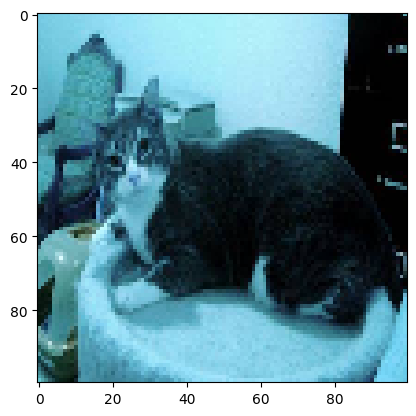

In [6]:
plt.imshow(cat_training[0],cmap='gray')

In [7]:
x_train=np.append(cat_training,dog_training,axis=0)
x_test=np.append(cat_testing,dog_testing,axis=0)
x_train.shape

(8005, 100, 100, 3)

In [8]:
y_train=np.array([0]*len(cat_training)+[1]*len(dog_training))
y_test=np.array([0]*len(cat_testing)+[1]*len(dog_testing))
print(y_test.shape)

(2023,)


In [9]:
y_train[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
y_train=torch.from_numpy(y_train.reshape(len(y_train),1))
y_test=torch.from_numpy(y_test.reshape(len(y_test),1))
y_test.shape

torch.Size([2023, 1])

In [11]:
# this is a dataset class.
# storing the dataset with labels. 
class Cat_Dog_Dataset():
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        if self.transform:
            image = self.transform(image)
        
        return (image, label)

In [12]:
transformers_test=transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])



train_dataset = Cat_Dog_Dataset(images=x_train, labels=y_train, transform=transformers_test)
test_dataset  = Cat_Dog_Dataset(images=x_test, labels=y_test, transform=transformers_test)

In [13]:
train_loader=DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader=DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn0 = nn.BatchNorm2d(num_features=16)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=32)
       
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        
        # 4 convolutional layers.
        # so actually when you get fractional results with this formula, then you round off.
        # the formula is (input height-kernel height +2*padding)/stride +1
        # for pooling, just divide by two.(pooling kernel size.)
        self.dropout = nn.Dropout(p=0.5)
        # here the number of in features equals to the output height * output width * number of channels.
        self.fc0 = nn.Linear(in_features=128*6*6, out_features=64)
        self.fc1 = nn.Linear(in_features=64, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.bn0(self.conv0(x)))
        x = self.maxpool(x)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = x.reshape(x.shape[0], -1)
        
        x = self.dropout(x)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        
        return x 

In [15]:
model=CNN()
loss_function=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)


In [16]:
def predict_test_data(model, test_loader):
    
    num_correct = 0
    num_samples = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.float()
            y_test = y_test.float()

            # Calculate loss (forward propagation)
            test_preds = model(X_test)
            test_loss  = loss_function(test_preds, y_test)
            
            # Calculate accuracy
            rounded_test_preds = torch.round(test_preds)
            num_correct += torch.sum(rounded_test_preds == y_test)
            num_samples += len(y_test)
        
    model.train()
    
    test_acc = num_correct/num_samples
    
    return test_loss, test_acc

In [17]:
train_losses=[]
test_losses=[]
train_accs=[]
test_accs=[]

for epoch in range(3):
    num_correct=0
    num_samples=0
    
    for batch, (x_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x_train=x_train.float()
        y_train=y_train.float()
        
        train_preds=model(x_train)
        train_loss=loss_function(train_preds, y_train)
        
        with torch.no_grad():
            rounded_train_preds=torch.round(train_preds)
            num_correct+=torch.sum(rounded_train_preds==y_train)
            num_samples+=len(y_train)
            
        optimizer.zero_grad()
        train_loss.backward()
        
        optimizer.step()
        
    train_acc=num_correct/num_samples
    test_loss, test_acc=predict_test_data(model, test_loader)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accs.append(train_acc.item())
    test_accs.append(test_acc.item())
    
    print(f'Epoch: {epoch} \t|' \
           
            f' Test loss: {np.round(test_loss.item(),3)} \t|' \
            
            f' Test acc: {np.round(test_acc.item(),2)}')

100%|██████████| 250/250 [00:51<00:00,  4.86it/s]


Epoch: 0 	| Test loss: 0.242 	| Test acc: 0.75


100%|██████████| 250/250 [00:51<00:00,  4.85it/s]


Epoch: 1 	| Test loss: 0.203 	| Test acc: 0.76


100%|██████████| 250/250 [00:51<00:00,  4.87it/s]


Epoch: 2 	| Test loss: 0.167 	| Test acc: 0.8


So, the accuracy after 3 epochs is 80 percent.
